### EDA

#### Зависимости

In [1]:
import boto3
import pandas as pd
import pickle
from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import nltk
import numpy as np
from tqdm import tqdm

tqdm.pandas()
nltk.download('stopwords')
pd.options.mode.chained_assignment = None
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rjcnz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Данные

In [2]:
ACCESS_KEY = ''
SECRET_KEY = ''

In [3]:
BUCKET = "habr-hse"
PATH = "datasets/2023/articles.pkl"

In [4]:
s3_client = boto3.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY
)

In [5]:
%%time

df_orig = pickle.loads(s3_client.get_object(Bucket=BUCKET, Key=PATH).get('Body').read())
len_df_orig = len(df_orig)
print(len_df_orig)
df_orig.head(5)

20000
Wall time: 30.6 s


,id,title,text,time,hubs,tags
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Информационная безопасность *|Платежные систем...,сбер|банкомат|процессинг
1,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,PHP *|Программирование *|Совершенный код *,codesmell|php|разработка сайтов|код|программир...
2,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,Информационная безопасность *|Социальные сети ...,it-компании|vk id|пароли|вконтакте|соцсети
3,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,Go *,mux|роутинг
4,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,Разработка под Android *|Гаджеты |Смартфоны |И...,xiaomi|hyperos|операционные системы|ос|мобильн...


In [6]:
print('Максимум хабов:', df_orig['hubs'].apply(lambda text: len(text.replace('*', '').split('|'))).max())

Максимум хабов: 6


In [7]:
df = df_orig.drop('id', axis=1)
df['time'] = df['time']
df['tags'] = df['tags'].apply(lambda tags: tags.split('|'))
df['hubs'] = df['hubs'].apply(lambda hubs: hubs.replace('*', '').split('|'))
df_list = []
for i in tqdm(range(len(df))):
    df_i = df.iloc[[i]*len(df[i:i+1]['hubs'].values[0])]
    df_i['hubs'] = [label for label in df_i['hubs'].values[0]]
    df_list.append(df_i)
df = pd.concat(df_list)
print(len(df))
df.head(5)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 6255.87it/s]


63367


,title,text,time,hubs,tags
0,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Информационная безопасность,"[сбер, банкомат, процессинг]"
0,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Платежные системы,"[сбер, банкомат, процессинг]"
0,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,IT-инфраструктура,"[сбер, банкомат, процессинг]"
0,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Облачные сервисы,"[сбер, банкомат, процессинг]"
0,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Финансы в IT,"[сбер, банкомат, процессинг]"


#### Анализ целевой переменной

In [8]:
print(f'В среднем одна статься имеет: {len(df)/len_df_orig} категории')

В среднем одна статься имеет: 3.16835 категории


In [9]:
df['hubs'].value_counts()

IT-компании                     3324
Информационная безопасность     1782
Научно-популярное               1759
Искусственный интеллект         1690
Программирование                1415
                                ... 
Блог компании Битрикс24            1
Блог компании LumanBox             1
Блог компании Хекслет              1
Блог компании Raft                 1
Small Basic                        1
Name: hubs, Length: 744, dtype: int64

In [10]:
print(f"Всего уникальных категорий: {len(df['hubs'].unique())}")

Всего уникальных категорий: 744


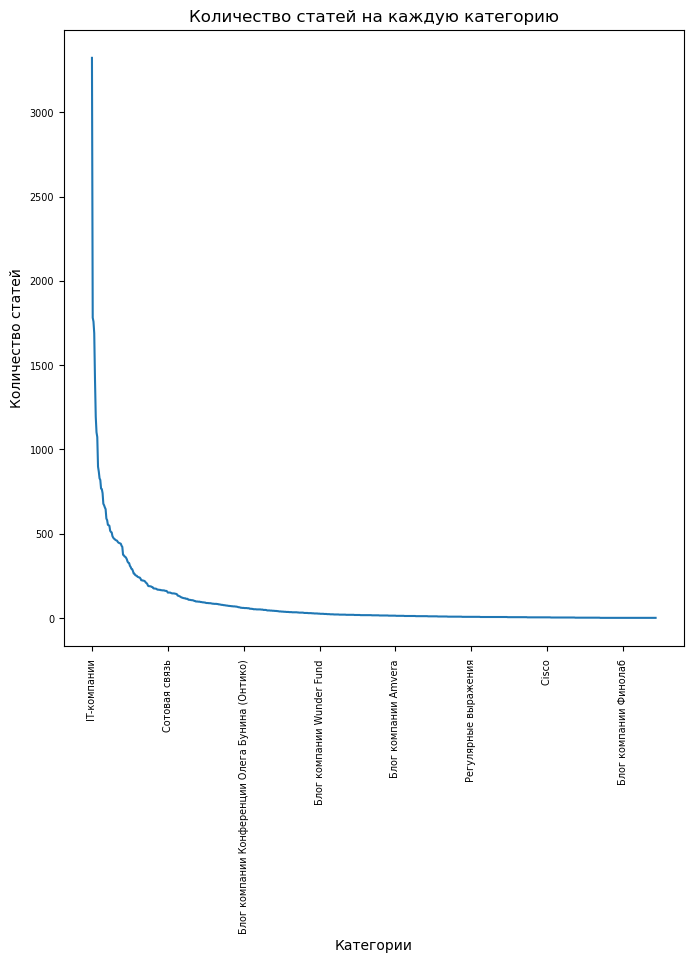

In [11]:
df['hubs'].value_counts().plot(figsize=(8, 8))
plt.xticks(rotation='vertical')
plt.title('Количество статей на каждую категорию')
plt.ylabel('Количество статей')
plt.xlabel('Категории')
plt.tick_params(labelsize = 7)
plt.show()

Из графика видно, что большинство категорий упоминаются лишь несколько раз, их можно обьединить или отбросить

#### Выделение тегов для каждой категории

По проставленным к статьям тегам

In [12]:
df_tags = df[['hubs', 'tags']].groupby('hubs').agg(sum).reset_index()
df_tags.sample(5)

,hubs,tags
709,Тестирование IT-систем,"[pentest, activedirectory, redteam, sliver, pe..."
609,Микроформаты,"[микроразметка, nuxt.js, seo-оптимизация, прод..."
50,Eclipse,"[eclipse, 4diac, kasperskyos, gpio, alphabot, ..."
553,Восстановление данных,"[disaster recovery, облачные сервисы, облако, ..."
275,Блог компании Innovative People,"[qa, management, управление, тестирование, ком..."


In [13]:
def chms_words(list_tags):
    res_dict = {}
    for tag in list_tags:
        if tag in res_dict:
            res_dict[tag] += 1
        else:
            res_dict[tag] = 1
    return {k: ((v/len(list_tags))*1_000_000) for k, v in sorted(res_dict.items(), key=lambda item: item[1], reverse=True)}

In [14]:
def get_top_tags(chms_tags, chms_all_tags, threshold_div, threshold_chms):
    tags = []
    for tag in chms_tags:
        if (chms_tags[tag]/chms_all_tags.get(tag, 1_000_000)>threshold_div) and (chms_tags[tag]>threshold_chms):
            tags.append(tag)
        if len(tags) == 10:
            break
    return tags

In [15]:
all_tags = [i for j in df_tags['tags'].values for i in j]
chms_all_tags = chms_words(all_tags)
list(chms_all_tags.items())[:5]

[('искусственный интеллект', 6803.9178148816945),
 ('python', 4498.8642890035235),
 ('программирование', 3727.9260727165483),
 ('chatgpt', 3526.1368751649243),
 ('машинное обучение', 3368.3273745155766)]

In [16]:
len(set(all_tags))

33970

In [17]:
df_tags['key_tags_from_tags'] = [get_top_tags(chms_words(tags), chms_all_tags, 
                                         threshold_div=1.2, threshold_chms=20_000) for tags in df_tags['tags'].values]
with pd.option_context("display.max_colwidth", None):
    display(df_tags[['hubs', 'key_tags_from_tags']].sample(50))

,hubs,key_tags_from_tags
230,Блог компании Comindware,"[автоматизация бизнес-процессов, low-code, comindware, управление проектами, bpm, управление бизнес-процессами, цифровая трансформация]"
153,Solidity,"[solidity, blockchain, смарт-контракты, smartcontract, ethereum, web3, evm, foundry, hardhat, truffle]"
102,Laravel,"[laravel, php]"
123,OpenStreetMap,"[openstreetmap_h3, экология, postgis, безопасное жилье, openstreetmap, урабанистика, PostGIS, открытые данные, карты, новости]"
355,Блог компании TEAMLY,"[knowledge management, управление знаниями, база знаний, менеджмент знаний, knowledge management system, искусственный интеллект, система управления знаниями, внедрение, автоматизация рутины, управление информацией]"
716,Умный дом,"[умный дом, автоматизация]"
541,ВКонтакте API,"[вконтакте, vk, python, автопостинг, вк, calendar, vkonakte, Goggle Calendar, vk api, google api]"
336,Блог компании Sapiens solutions,"[arenadata db, nlp, ai, аналитика данных, big data, business analytics, миграция, cosmic, оценка проекта, миграция dwh]"
384,Блог компании Zextras,"[carbonio, zextras, электронная почта, carbonio ce]"
314,Блог компании Privacy Accelerator,"[python, getsitecopy, privacy accelerator, обход блокировок, обход цензуры, demhack, хакатон, telegram bot, хакатоны, hackathon]"


Случайная визуализация топ тегов

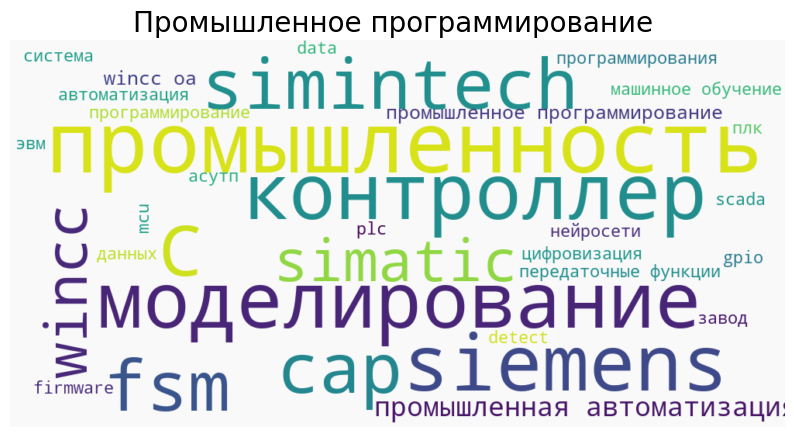

In [74]:
num_hub = np.random.randint(len(df_tags))

wordcloud = wordcloud = WordCloud(
        min_font_size=8,
        scale=2.5,
        background_color='#F9F9FA',
        ).generate(' '.join(df_tags['tags'].values[num_hub]))
plt.figure(figsize=(10, 10))
plt.title(df_tags['hubs'].values[num_hub], fontsize=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

По всем словам

In [18]:
morph = MorphAnalyzer()
morph.parse('позвони')[0].normal_form

'позвонить'

In [19]:
def get_tokens(text, morph=morph):
    return [morph.parse(word)[0].normal_form for word in text.replace('\n', ' ').split()]

In [4]:
%%time

df['tokens'] = df['text'].parallel_apply(get_tokens)
with open('df_tokens.pkl', 'wb') as f:
    pickle.dump(df, f)
df.sample(5)

,title,text,time,hubs,tags,tokens
6644,Реально Бесконечное (лето) RuGPT3.5: Генерация...,"Что это за мировая линия?Я уж было подумал, чт...",10 авг в 07:00,Игры и игровые консоли,"[новеллы, text generation, text adventure, gpt...","[что, это, за, мировой, линия?ть, уж, быть, по..."
1857,Нейроинтерфейсы от Neuralink: проблемы и персп...,"О Neuralink, компании Илона Маска, которая зан...",26 сен в 09:52,Блог компании МТС,"[научное, научно-популярное, мозг, будущее, бу...","[о, neuralink,, компания, илона, маска,, котор..."
11009,Обновление fheroes2 — открытого движка Heroes ...,В конце 2022 года открытый игровой движок Геро...,13 июн в 10:18,Дизайн,"[heroes of might and magic ii, fheroes2, open ...","[в, конец, 2022, год, открытый, игровой, движо..."
15262,Opera представила новый браузер Opera One,\n\n25 апреля 2023 года Opera представила Oper...,25 апр в 11:55,Искусственный интеллект,"[Opera, ИИ, браузер, Opera One]","[25, апрель, 2023, год, opera, представить, op..."
1467,Системы искусственного интеллекта Smart Engine...,Российский разработчик систем искусственного и...,29 сен в 13:55,Искусственный интеллект,"[искусственный интеллект, ии, хостинги, распоз...","[российский, разработчик, система, искусственн..."


In [2]:
with open('df_tokens.pkl', 'rb') as f:
    df = pickle.load(f)

In [24]:
%%time

df_tokens = df[['hubs', 'tokens']].groupby('hubs').agg(sum).reset_index()
df_tokens.sample(5)

Wall time: 5min 5s


,hubs,tokens
494,Блог компании Ростелеком-Солар,"[объём, данные, для, хранение, и, обработка, р..."
196,Биотехнологии,"[новый, магнитоэлектрический, материал, —, пер..."
470,Блог компании Нанософт разработка,"[как, выпускник, вуз, стать, член, перспективн..."
142,SCADA,"[весь, привет!ич, habr, есть, интересный, стат..."
378,Блог компании X5 Tech,"[приветствовать, весь, читателей!, сегодня, ко..."


In [25]:
all_tokens = [i for j in df_tokens['tokens'].values for i in j]
chms_all_tokens = chms_words(all_tokens)
list(chms_all_tokens.items())[:5]

[('в', 29642.53197451647),
 ('и', 28638.716191553467),
 ('на', 15112.798598524865),
 ('с', 12319.43345523731),
 ('не', 9914.307088721984)]

In [37]:
df_tags['key_tags_from_words'] = [get_top_tags(chms_words(tokens), chms_all_tokens, 
                                         threshold_div=10.0, threshold_chms=2_000) for tokens in df_tokens['tokens'].values]
with pd.option_context("display.max_colwidth", None):
    display(df_tags[['hubs', 'key_tags_from_tags', 'key_tags_from_words']].sample(50))

,hubs,key_tags_from_tags,key_tags_from_words
202,Блог компании AIRI,"[машинное обучение, нейросети, робототехника, искусственный интеллект]",[агент]
412,Блог компании БАРС Груп,"[барс груп, GraphQL API, кибербезопасность, защита данных, graphql, HotChocolate, защита api, обработка запросов, бизнес-приложения]","[graphql, запрос, вложенность, интроспекция, защита, схема, запрашивать, запрос,, правило, средство]"
490,Блог компании РосКомСвобода,"[приватность, vpn, блокировки, цензура, права человека, кибербезопасность, стартапы, хакатоны, персональные данные, утечки]","[защита, утечка, хакатон, vpn, блокировка]"
62,Fortran,"[fortran, фортран, программирование, параллельное программирование, история, linuxformat, mike bedford, задача, производительность, Бэкус]","[фортран, !, +, fortran, do, язык, оператор, m2, ::, компилятор]"
701,Стандарты связи,"[сотовая связь, операторы связи]","[[rs485], :i, isanybodywith, сигнал, оператор, телефон]"
148,Serverless,"[serverless, ydb, python, yandex.cloud, telegram, pytelegrambotapi, telebot, serverless containers, telegrambot, step-by-step]","[бот, сообщение, serverless, обработчик, контейнер, def]"
426,Блог компании ГК ЛАНИТ,"[ланит, artezio]",[―]
587,Кодобред,"[программирование, reinterpret_cast, java, android, unsafe, ненормальное программирование]","[public, int, class]"
207,Блог компании Altcraft,"[digital маркетинг, маркетинг, интернет маркетинг, маркетинговая стратегия, маркетинг в интернете, email маркетинг, цифровой маркетинг, email рассылки, cdp платформа]","[клиент, письмо, электронный, рассылка, нейронный, ия, бренд]"
288,Блог компании MOEX,"[московская биржа, platform engineering, разработка, moex, корпоративные системы, платформа, цифровой опыт, conways law, дизайн-система, cms]","[отчёт, платформа, цифровой]"


In [38]:
with open('df_tags.pkl', 'wb') as f:
    pickle.dump(df_tags, f)

Случайная визуализация топ тегов

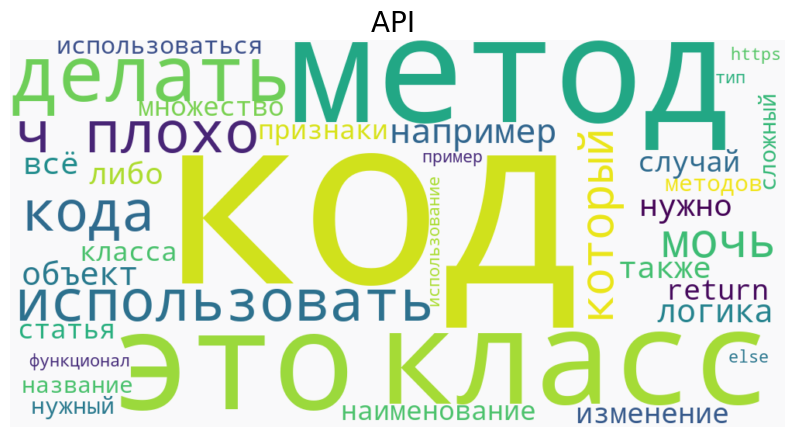

In [70]:
num_hub = np.random.randint(len(df_tags))

wordcloud = wordcloud = WordCloud(
        stopwords=nltk.corpus.stopwords.words("russian"),
        min_font_size=8,
        scale=2.5,
        background_color='#F9F9FA',
        ).generate(' '.join(df['tokens'].values[num_hub]))
plt.figure(figsize=(10, 10))
plt.title(df_tags['hubs'].values[num_hub], fontsize=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### 2-d визуализация

In [3]:
tfidf_vec = TfidfVectorizer(analyzer='word', min_df=1000, stop_words=nltk.corpus.stopwords.words("russian"))
df['tfidf_vec'] = [i for i in tfidf_vec.fit_transform(df['tokens'].apply(' '.join).values).toarray()]
print(len(df['tfidf_vec'].values[0]))

4830


In [6]:
%%time

tsne_vec = TSNE(n_components=2, n_jobs=-1)
df['tsne_vec'] = [j for j in tsne_vec.fit_transform([i for i in df['tfidf_vec'].values])]
print(len(df['tsne_vec'].values[0]))

C:\Users\rjcnz\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\rjcnz\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


2
Wall time: 6min 23s


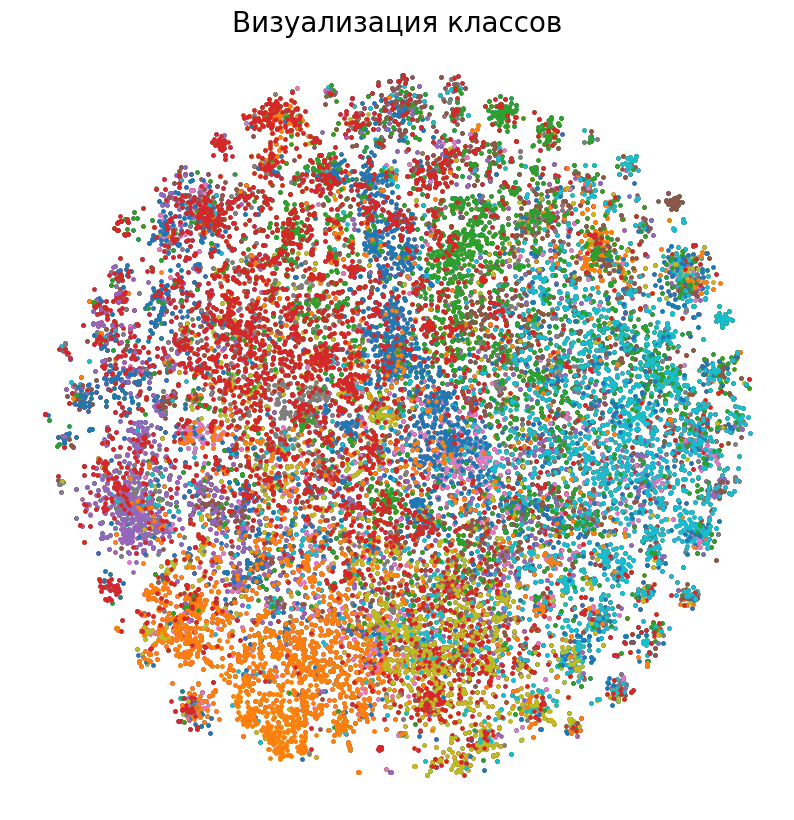

In [26]:
plt.figure(figsize=(10, 10))
for hub in df['hubs'].value_counts(ascending=True).index:
    df_i = df[df['hubs']==hub]
    plt.scatter(df_i['tsne_vec'].apply(lambda vec: vec[0]), df_i['tsne_vec'].apply(lambda vec: vec[1]), s=5.0)
plt.title('Визуализация классов', fontsize=20)
plt.axis("off")
plt.show()

Из графика видно, что классы довольно хорошо группируются, а значит они хорошо разделимы, что прогнозирует хорошие метрики для предстоящей задачи классификации